In [1]:
# Importing matplotlib for plotting
import matplotlib.pyplot as plt

# Importing numpy for numerical operations
import numpy as np

# Importing pandas for preprocessing
import pandas as pd

# Importing joblib to dump and load embeddings df
import joblib

# Importing cv2 to read images
import cv2

# Importing cosine_similarity to find similarity between images
from sklearn.metrics.pairwise import cosine_similarity
# Importing flatten from pandas to flatten 2-D array
from pandas.core.common import flatten

# Importing the below libraries for our model building
#import torch
import torch
import torch.nn as nn

#import cv models
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable

#import image
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importing the metadata
df = pd.read_csv('myntradataset/styles.csv',error_bad_lines=False,warn_bad_lines=False)
#C:\Users\hp\OneDrive\Documents\books\important\Computer Vision Projects with PyTorch\chapter5\myntradataset
#top 10 rows
df.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012.0,Casual,Puma Men Pack of 3 Socks
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Skagen Men Black Watch


<AxesSubplot:>

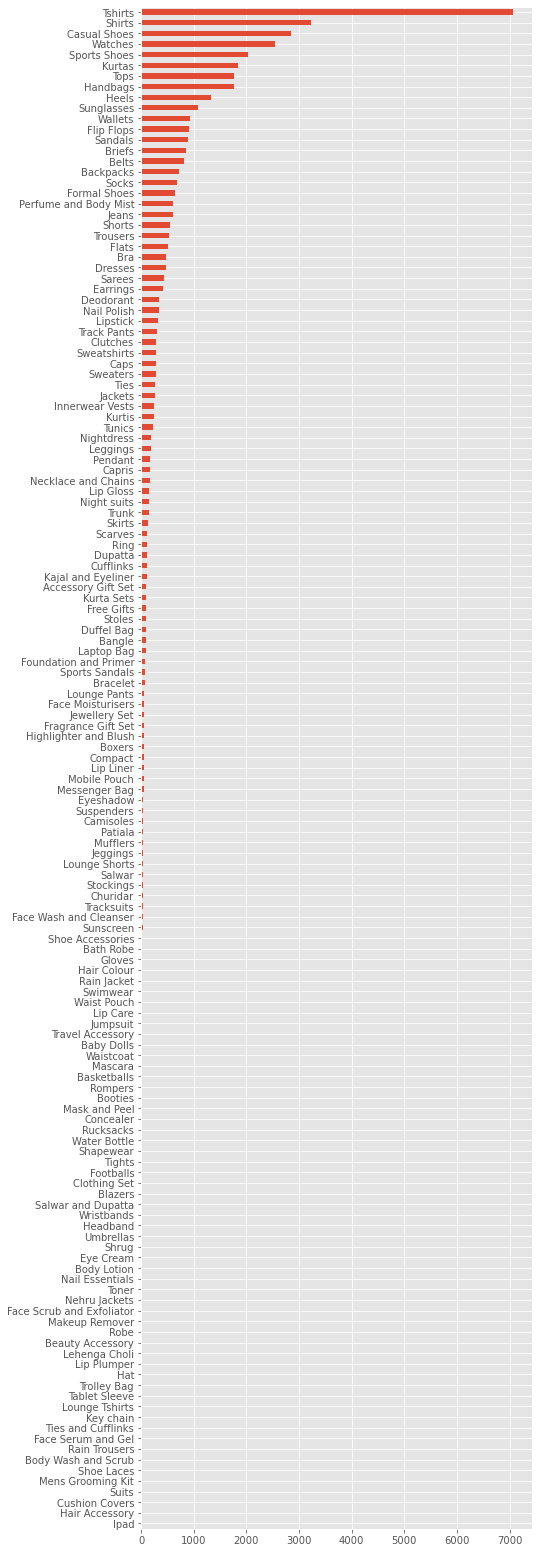

In [3]:
#set style
plt.style.use('ggplot')
# Understanding the data, how many different articleType are present and knowing their frequency
plt.figure(figsize=(7,28))
df.articleType.value_counts().sort_values().plot(kind='barh')

In [4]:
#creating column to store image location ids
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
#reseting the index
df = df.reset_index(drop=True)
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg


In [5]:
def image_location(img):
    return 'myntradataset/images/' + img
# function to load image
def import_img(image):
    image = cv2.imread(image_location(image))
    return image

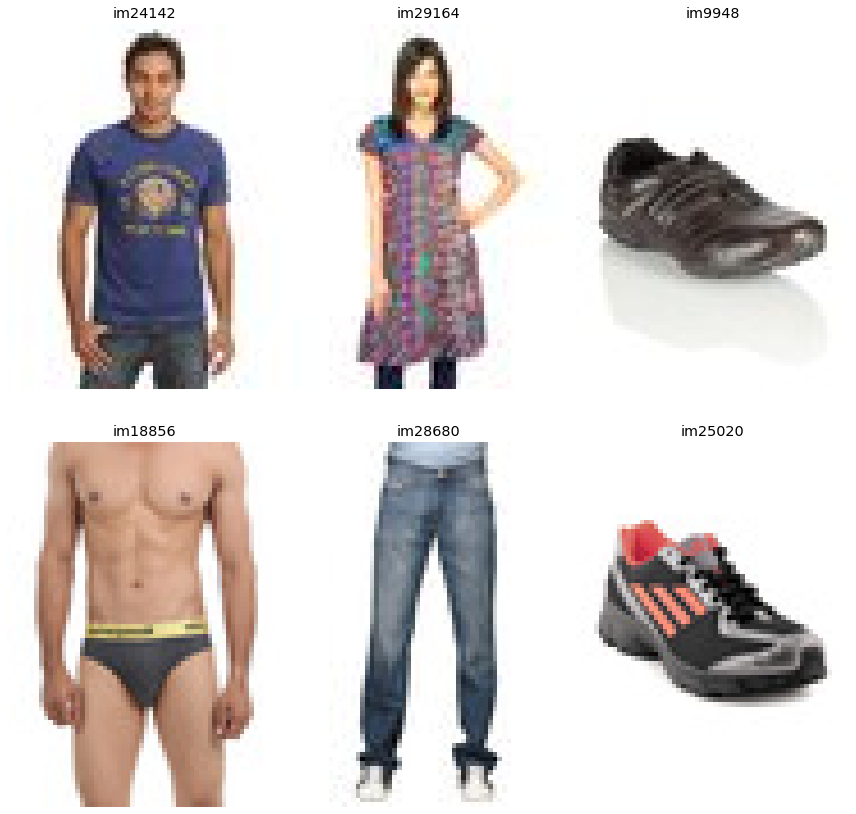

In [6]:
def show_images(images, rows = 1, cols=1,figsize=(12, 12)):
    #define fig
    fig, axes = plt.subplots(ncols=cols,nrows=rows,figsize=figsize)
 #loop for images
    for index,name in enumerate(images):
        axes.ravel()[index].imshow(cv2.cvtColor(images[name],cv2.COLOR_BGR2RGB))
        axes.ravel()[index].set_title(name)
        axes.ravel()[index].set_axis_off()
    #plot
    plt.tight_layout()
# Generation of a dictionary of {index, image}


figures = {'im'+str(i): import_img(row.image) for i, row in df.sample(6).iterrows()}
# Plotting the images in a figure, with 2 rows and 3 columns
show_images(figures, 2, 3)


In [7]:
# Defining the input shape
width= 224
height= 224
# Loading the pretrained model
resnetmodel = models.resnet18(pretrained=True)
# selecting the layer
layer = resnetmodel._modules.get('avgpool')
#evaluation
resnetmodel.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
layer

AdaptiveAvgPool2d(output_size=(1, 1))

In [9]:
# scaling the data
s_data = transforms.Resize((224, 224))
# normalizing
standardize = transforms.Normalize(mean=[0.7, 0.6, 0.3],std=[0.2, 0.3, 0.1])
# converting to tensor
convert_tensor = transforms.ToTensor()
# creating the missing image object
missing_img = []
#function to get embeddings
def vector_extraction(resnetmodel, image_id):
    # exception handling to ignore missing images
    try:
        img = Image.open(image_location(image_id)).convert('RGB')
        t_img = Variable(standardize(convert_tensor(s_data(img))).unsqueeze(0))
        embeddings = torch.zeros(512)
        def select_d(m, i, o):
            embeddings.copy_(o.data.reshape(o.data.size(1)))
        hlayer = layer.register_forward_hook(select_d)
        resnetmodel(t_img)
        hlayer.remove()
        emb = embeddings
        return embeddings
    # If file not found
    except FileNotFoundError:
    # Store the index of such entries in missing_img list and drop them later
        missed_img = df[df['image']==image_id].index
        print(missed_img)
        missing_img.append(missed_img)

(80, 60, 3)
tensor([3.6048e-01, 9.8693e-01, 2.3240e-01, 1.6690e+00, 3.1513e-01, 7.5393e-01,
        4.3338e-01, 1.2030e-01, 1.6725e+00, 1.5513e+00, 1.8964e-01, 8.2587e-01,
        5.1050e-01, 8.5980e-02, 9.8755e-03, 1.3050e-01, 9.9360e-01, 1.2246e-01,
        1.6302e-01, 1.8046e+00, 9.4435e-01, 1.3779e+00, 2.1519e+00, 4.8767e-01,
        1.2682e-01, 3.1091e-01, 8.3039e-01, 3.0100e+00, 7.7897e-02, 4.9649e-01,
        8.5514e-01, 3.0350e-01, 3.5636e-01, 2.3899e+00, 9.0330e-01, 1.1726e+00,
        4.6758e-01, 4.2146e-01, 8.5769e-01, 5.5814e-01, 5.1486e-01, 2.2462e-01,
        1.3500e-01, 1.5317e+00, 2.5450e+00, 2.7813e-01, 1.1332e-01, 2.9904e-01,
        2.4004e+00, 5.8370e-01, 1.5316e+00, 1.1459e+00, 6.3753e-01, 5.5374e-01,
        6.6281e-01, 6.9787e-01, 1.4696e-01, 3.6548e+00, 9.4378e-01, 1.4293e+00,
        2.0492e-01, 5.9428e-01, 5.4688e-01, 5.0279e-01, 2.0592e-01, 5.0718e-02,
        1.2491e+00, 3.5593e-01, 1.1399e+00, 1.3888e+00, 5.4131e-02, 1.7949e+00,
        2.5154e-01, 2.1635e-

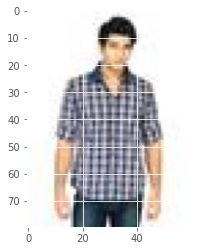

In [10]:
# Testing if our vector_extraction function works well on sample image
sample_embedding_0 = vector_extraction(resnetmodel,df.iloc[0].image)
# Plotting the sample image and its embeddings
img_array = import_img(df.iloc[0].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(sample_embedding_0)

(80, 60, 3)
tensor([2.2214e-01, 4.8201e-01, 1.4577e+00, 2.0319e+00, 7.2153e-02, 1.1472e+00,
        3.7525e-01, 1.2374e-01, 1.2103e+00, 1.6589e+00, 4.6383e-01, 1.1207e+00,
        1.8761e-01, 1.6882e-01, 7.9731e-02, 9.6742e-01, 3.4295e-01, 6.1189e-01,
        1.4849e-01, 2.1886e+00, 4.2695e-01, 7.3654e-01, 2.2325e+00, 7.4541e-01,
        3.7189e-01, 2.1022e-01, 2.0852e-01, 3.8510e+00, 0.0000e+00, 7.6034e-01,
        5.2886e-01, 5.1996e-02, 4.3434e-01, 2.9405e+00, 3.0286e+00, 7.1146e-02,
        5.4161e-01, 1.2275e-01, 1.0301e+00, 8.6784e-01, 2.9940e-01, 2.2237e-01,
        2.0470e-01, 5.1393e-01, 8.8564e-01, 1.4416e+00, 4.1729e-01, 1.9291e-01,
        1.4389e+00, 4.5813e-01, 2.1016e+00, 1.2736e+00, 2.7155e-01, 5.5243e-01,
        7.0722e-01, 9.0096e-01, 3.1049e-02, 1.2802e+00, 7.3365e-01, 5.1611e-01,
        2.2345e-01, 1.3885e-01, 1.7405e+00, 1.2096e+00, 5.0332e-01, 7.8591e-01,
        1.8049e+00, 2.8785e-02, 4.2256e-01, 9.1534e-01, 1.3768e+00, 1.5604e+00,
        2.5527e-01, 7.8376e-

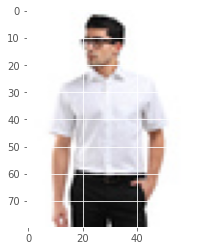

In [11]:
# Testing if our vector_extraction function works well on sample image
sample_embedding_1 = vector_extraction(resnetmodel,df.iloc[1000].image)
# Plotting the sample image and its embeddings
img_array = import_img(df.iloc[1000].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(sample_embedding_1)

In [12]:
#Finding the similarity between those two images
cos_sim = cosine_similarity(sample_embedding_0.unsqueeze(0), sample_embedding_1.unsqueeze(0))
print('\nCosine similarity: {0}\n'.format(cos_sim))



Cosine similarity: [[0.86287767]]



In [13]:
df.count()

id                    44424
gender                44424
masterCategory        44424
subCategory           44424
articleType           44424
baseColour            44409
season                44403
year                  44423
usage                 44107
productDisplayName    44417
image                 44424
dtype: int64

In [ ]:
%%time
import swifter
# Applying embeddings on subset of this huge dataset
#df_embeddings = df[:100] #We can apply on entire df, like: 
df_embeddings = df
#looping through images to get embeddings
map_embeddings = df_embeddings['image'].swifter.apply(lambda img: vector_extraction(resnetmodel, img))
#convert to series
df_embs = map_embeddings.apply(pd.Series)
print(df_embs.shape)
df_embs.head()

Pandas Apply:   0%|          | 0/44424 [00:00<?, ?it/s]

Int64Index([6695], dtype='int64')
Int64Index([16194], dtype='int64')
Int64Index([32309], dtype='int64')
Int64Index([36381], dtype='int64')
Int64Index([40000], dtype='int64')


In [ ]:
#export the embeddings
df_embs.to_csv('df_embs.csv')

In [14]:
# importing the embeddings
df_embs = pd.read_csv('df_embs.csv')
#df_embs.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1,inplace=True)
df_embs.drop(['Unnamed: 0'],axis=1,inplace=True)
df_embs.dropna(inplace=True)

In [15]:
df_embs

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.360482,0.986929,0.232400,1.669047,0.315127,0.753928,0.433384,0.120297,1.672540,1.551313,...,0.599806,0.879021,2.274732,0.550261,0.000889,0.135181,1.871303,1.418938,0.000000,0.523687
1,0.754325,0.232688,0.522140,2.608785,0.838683,0.135893,0.427806,0.854116,0.601940,2.225886,...,0.222548,0.424173,0.006582,0.189141,0.000000,0.156890,1.189896,0.405764,0.087880,0.134553
2,0.331700,0.240245,3.068739,2.655947,0.009184,0.013017,3.198415,0.591138,3.220150,4.040012,...,0.303095,3.104079,1.619334,0.973718,0.458845,0.000000,1.401979,0.908382,0.000000,0.000000
3,0.624760,0.258359,0.544933,2.922384,0.353659,0.141806,0.799510,0.617607,0.298829,0.843662,...,0.320797,0.392780,0.261848,0.159667,0.000000,0.005314,0.677280,0.223054,0.063506,0.190919
4,0.452778,0.649997,0.348728,1.654590,0.135157,1.385382,0.481832,0.515382,2.859257,1.028549,...,0.432272,0.875069,1.472380,0.889062,0.074484,0.321773,1.748126,0.052523,0.000000,0.241553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44419,2.140327,1.214761,1.633095,3.217753,0.020966,0.031269,1.809171,0.420596,0.887958,0.479052,...,1.516155,1.167218,0.004386,0.325264,0.034396,0.398723,1.654329,0.718042,0.209313,1.065168
44420,2.736523,0.548147,1.612591,1.531540,0.001839,0.166323,0.978719,0.381998,1.446862,0.985562,...,1.247631,1.484404,0.657427,0.911372,0.171788,0.098936,0.000000,0.079138,0.004161,0.048924
44421,0.386329,0.050175,0.596431,1.689547,0.110630,0.264591,0.229274,0.251138,1.034564,1.010781,...,0.013314,0.372312,0.672706,0.769500,0.007260,0.314997,0.501299,0.425188,0.035810,0.037991
44422,0.217149,0.099973,1.204358,1.860558,0.005333,0.409807,1.044022,0.979830,0.588969,0.968008,...,0.112295,1.849876,1.025921,0.324506,0.144285,0.099355,2.299005,0.725327,0.397350,0.539336


#exporting as pkl
joblib.dump(df_embs, 'df_embs.pkl', 9)

#importing the pkl
df_embs = joblib.load('df_embs.pkl')

In [16]:
# Calculating similarity between images ( using embedding values )
cosine_sim = cosine_similarity(df_embs)
# Previewing first 4 rows and 4 columns similarity just to check the structure of cosine_sim
cosine_sim[:4, :4]

array([[1.        , 0.74040617, 0.61466263, 0.77031877],
       [0.74040617, 1.        , 0.63943807, 0.87482631],
       [0.61466263, 0.63943807, 1.        , 0.604874  ],
       [0.77031877, 0.87482631, 0.604874  , 1.        ]])

In [17]:
# Storing the index values in a series index_vales for recommending
index_vales = pd.Series(range(len(df)), index=df.index)
index_vales
# Defining a function that gives recommendations based on the cosine similarity score
def recommend_images(ImId, df, top_n = 6):
    #Assigning index of reference into sim_ImId
    sim_ImId = index_vales[ImId]
    # Storing cosine similarity of all other items with item requested by user in sml_scr as a list
    sml_scr = list(enumerate(cosine_sim[sim_ImId]))
    # Sorting the list of sml_scr
    sml_scr = sorted(sml_scr, key=lambda x: x[1], reverse=True)
    #Extracting the top n values from sml_scr
    sml_scr = sml_scr[1:top_n+1]
    # ImId_rec will return the index of similar items
    ImId_rec = [i[0] for i in sml_scr]
    # ImId_sim will return the value of similarity score
    ImId_sim = [i[1] for i in sml_scr]
    return index_vales.iloc[ImId_rec].index, ImId_sim

In [18]:
# Sample given below
recommend_images(3810, df, top_n = 5)

(Int64Index([0, 6553, 32754, 3899, 37711], dtype='int64'),
 [0.967167659717159,
  0.9665616922154459,
  0.9632609492082511,
  0.9628880003652511,
  0.9626458419316073])

In [19]:
def Rec_viz_image(input_imageid):
    # Getting recommendations
    idx_rec, idx_sim = recommend_images(input_imageid, df,top_n = 6)
    # Printing the similarity score
    print (idx_sim)
    # Plotting the image of item requested by user
    plt.imshow(cv2.cvtColor(import_img(df.iloc[input_imageid].image), cv2.COLOR_BGR2RGB))
    # Generating a dictionary of { index, image }
    figures = {'im'+str(i): import_img(row.image) for i, row in df.loc[idx_rec].iterrows()}
    # Plotting the similar images in a figure, with 2 rows and 3 columns
    show_images(figures, 2, 3)

[0.967167659717159, 0.9665616922154459, 0.9632609492082511, 0.9628880003652511, 0.9626458419316073, 0.9619884030154036]


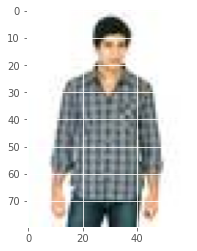

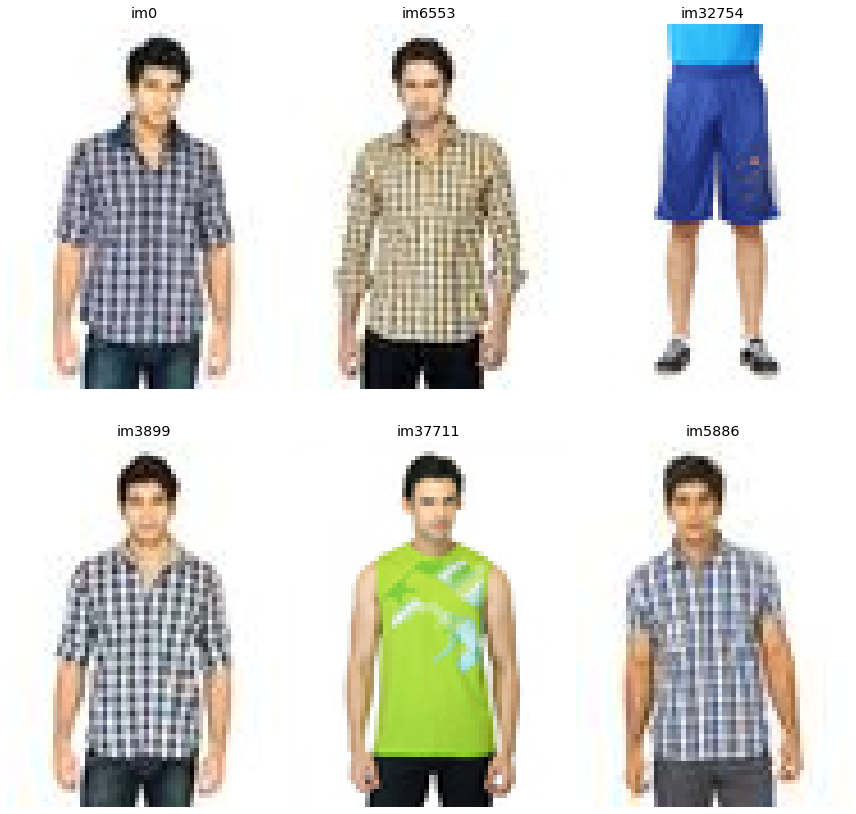

In [20]:
Rec_viz_image(3810)

[0.9840985412483675, 0.9822100575382262, 0.9802509903309097, 0.9800927447344233, 0.9799333269713983, 0.9768365220207376]


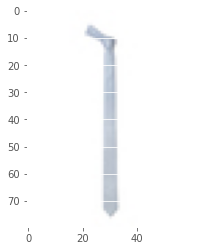

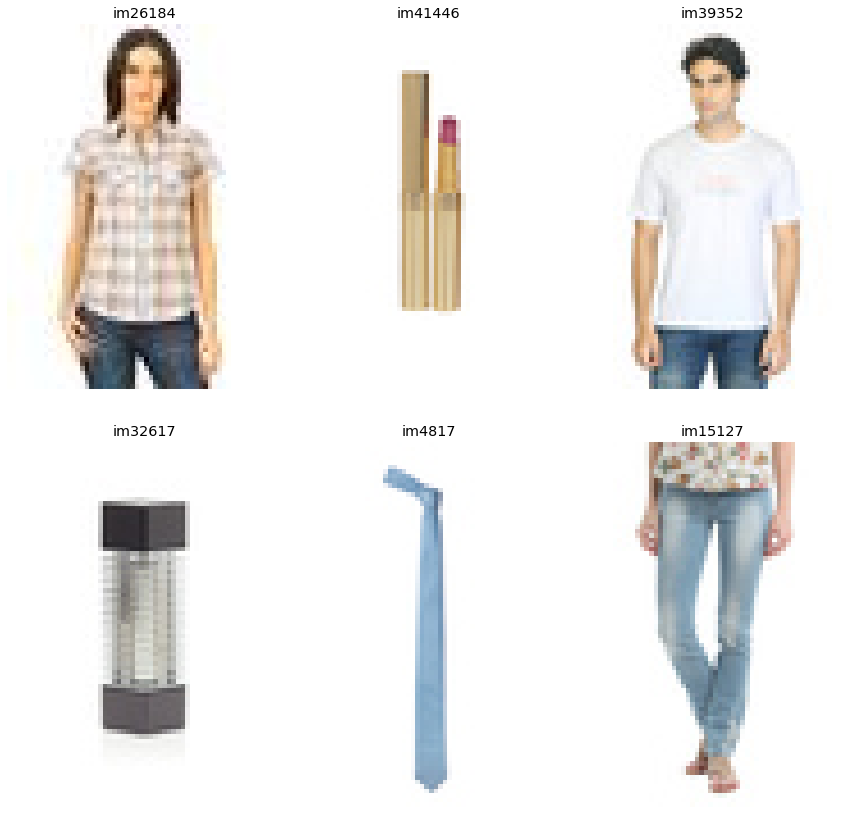

In [22]:
Rec_viz_image(2518)

In [34]:
def recm_user_input(image_id):
    # Loading image and reshaping it
    img = Image.open( image_id).convert('RGB')
    t_img = Variable(standardize(convert_tensor(s_data(img))).unsqueeze(0))
    embeddings = torch.zeros(512)
    def select_d(m, i, o):
        embeddings.copy_(o.data.reshape(o.data.size(1)))
    hlayer = layer.register_forward_hook(select_d)
    resnetmodel(t_img)
    hlayer.remove()
    emb = embeddings
    # Calculating Cosine Similarity
    cs = cosine_similarity(emb.unsqueeze(0),df_embs)
    cs_list = list(flatten(cs))
    cs_df = pd.DataFrame(cs_list,columns=['Score'])
    cs_df = cs_df.sort_values(by=['Score'],ascending=False)
    # Printing Cosine Similarity
    print(cs_df['Score'][:10])
    # Extracting the index of top 10 similar items/images
    top10 = cs_df[:10].index
    top10 = list(flatten(top10))
    images_list = []
    for i in top10:
        image_id = df[df.index==i]['image']
        images_list.append(image_id)
    images_list = list(flatten(images_list))
    # Plotting the image of item requested by user
    img_print = Image.open(image_id).convert('RGB')
    plt.imshow(img_print)
    # Generating a dictionary { index, image }
    figures = {'im'+str(i): Image.open('images/' + i) for i in images_list}
    # Plotting the similar images in a figure, with 2 rows and 3 columns
    fig, axes = plt.subplots(2, 5, figsize = (8,8) )
    for index,name in enumerate(figures):
        axes.ravel()[index].imshow(figures[name])
        axes.ravel()[index].set_title(name)
        axes.ravel()[index].set_axis_off()
    plt.tight_layout()

In [35]:
recm_user_input('test.jpg')

11172    0.820550
37720    0.817389
395      0.815062
40857    0.814167
492      0.813895
5492     0.813289
19002    0.813141
41935    0.812163
12391    0.811648
40480    0.810616
Name: Score, dtype: float64


AttributeError: 'Series' object has no attribute 'read'